In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
import addict
import scipy
import numpy as np
import matplotlib.pyplot as plt

import celeri

plt.rcParams["text.usetex"] = False

# KL+QP functions

In [3]:
def get_index(assembly, segment, station, block, meshes, mogi):
    # Create dictionary to store indices and sizes for operator building
    index = addict.Dict()
    index.n_blocks = len(block)
    index.n_segments = len(segment)
    index.n_stations = assembly.data.n_stations
    index.n_meshes = len(meshes)
    index.n_mogis = len(mogi)
    index.vertical_velocities = np.arange(2, 3 * index.n_stations, 3)
    index.n_block_constraints = assembly.data.n_block_constraints
    index.station_row_keep_index = celeri.get_keep_index_12(3 * index.n_stations)
    index.start_station_row = 0
    index.end_station_row = 2 * index.n_stations
    index.start_block_col = 0
    index.end_block_col = 3 * index.n_blocks
    index.start_block_constraints_row = index.end_station_row
    index.end_block_constraints_row = (
        index.start_block_constraints_row + 3 * index.n_block_constraints
    )
    index.n_slip_rate_constraints = assembly.data.slip_rate_constraints.size
    index.start_slip_rate_constraints_row = index.end_block_constraints_row
    index.end_slip_rate_constraints_row = (
        index.start_slip_rate_constraints_row + index.n_slip_rate_constraints
    )
    index.n_tde_total = 0
    index.n_tde_constraints_total = 0

    # A bunch of declarations of TDE-related indices as arrays, otherwise they're dicts
    index.n_tde = np.zeros(index.n_meshes, dtype=int)
    index.n_tde_constraints = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_col = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_col = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_smoothing_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_smoothing_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_top_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_top_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_bot_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_bot_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_side_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_side_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_coup_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_coup_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_ss_slip_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_ss_slip_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_ds_slip_constraint_row = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_ds_slip_constraint_row = np.zeros(index.n_meshes, dtype=int)

    for i in range(index.n_meshes):
        index.n_tde[i] = meshes[i].n_tde
        index.n_tde_total += index.n_tde[i]
        index.n_tde_constraints[i] = meshes[i].n_tde_constraints
        index.n_tde_constraints_total += index.n_tde_constraints[i]
        if i == 0:
            index.start_tde_col[i] = index.end_block_col
            index.end_tde_col[i] = index.start_tde_col[i] + 2 * index.n_tde[i]
            index.start_tde_smoothing_row[i] = index.end_slip_rate_constraints_row
            index.end_tde_smoothing_row[i] = (
                index.start_tde_smoothing_row[i] + 2 * index.n_tde[i]
            )
            index.start_tde_constraint_row[i] = index.end_tde_smoothing_row[i]
            index.end_tde_constraint_row[i] = (
                index.start_tde_constraint_row[i] + index.n_tde_constraints[i]
            )
            index.start_tde_top_constraint_row[i] = index.end_tde_smoothing_row[i]
            index.end_tde_top_constraint_row[i] = index.start_tde_top_constraint_row[
                i
            ] + len(meshes[i].top_slip_idx)
            index.start_tde_bot_constraint_row[i] = index.end_tde_top_constraint_row[i]
            index.end_tde_bot_constraint_row[i] = index.start_tde_bot_constraint_row[
                i
            ] + len(meshes[i].bot_slip_idx)
            index.start_tde_side_constraint_row[i] = index.end_tde_bot_constraint_row[i]
            index.end_tde_side_constraint_row[i] = index.start_tde_side_constraint_row[
                i
            ] + len(meshes[i].side_slip_idx)
            index.start_tde_coup_constraint_row[i] = index.end_tde_side_constraint_row[
                i
            ]
            index.end_tde_coup_constraint_row[i] = index.start_tde_coup_constraint_row[
                i
            ] + len(meshes[i].coup_idx)
            index.start_tde_ss_slip_constraint_row[i] = (
                index.end_tde_coup_constraint_row[i]
            )
            index.end_tde_ss_slip_constraint_row[i] = (
                index.start_tde_ss_slip_constraint_row[i] + len(meshes[i].ss_slip_idx)
            )
            index.start_tde_ds_slip_constraint_row[i] = (
                index.end_tde_ss_slip_constraint_row[i]
            )
            index.end_tde_ds_slip_constraint_row[i] = (
                index.start_tde_ds_slip_constraint_row[i] + len(meshes[i].ds_slip_idx)
            )
        else:
            index.start_tde_col[i] = index.end_tde_col[i - 1]
            index.end_tde_col[i] = index.start_tde_col[i] + 2 * index.n_tde[i]
            index.start_tde_smoothing_row[i] = index.end_tde_constraint_row[i - 1]
            index.end_tde_smoothing_row[i] = (
                index.start_tde_smoothing_row[i] + 2 * index.n_tde[i]
            )
            index.start_tde_constraint_row[i] = index.end_tde_smoothing_row[i]
            index.end_tde_constraint_row[i] = (
                index.start_tde_constraint_row[i] + index.n_tde_constraints[i]
            )
            index.start_tde_top_constraint_row[i] = index.end_tde_smoothing_row[i]
            index.end_tde_top_constraint_row[i] = index.start_tde_top_constraint_row[
                i
            ] + len(meshes[i].top_slip_idx)
            index.start_tde_bot_constraint_row[i] = index.end_tde_top_constraint_row[i]
            index.end_tde_bot_constraint_row[i] = index.start_tde_bot_constraint_row[
                i
            ] + len(meshes[i].bot_slip_idx)
            index.start_tde_side_constraint_row[i] = index.end_tde_bot_constraint_row[i]
            index.end_tde_side_constraint_row[i] = index.start_tde_side_constraint_row[
                i
            ] + len(meshes[i].side_slip_idx)
            index.start_tde_coup_constraint_row[i] = index.end_tde_side_constraint_row[
                i
            ]
            index.end_tde_coup_constraint_row[i] = index.start_tde_coup_constraint_row[
                i
            ] + len(meshes[i].coup_idx)
            index.start_tde_ss_slip_constraint_row[i] = (
                index.end_tde_coup_constraint_row[i]
            )
            index.end_tde_ss_slip_constraint_row[i] = (
                index.start_tde_ss_slip_constraint_row[i] + len(meshes[i].ss_slip_idx)
            )
            index.start_tde_ds_slip_constraint_row[i] = (
                index.end_tde_ss_slip_constraint_row[i]
            )
            index.end_tde_ds_slip_constraint_row[i] = (
                index.start_tde_ds_slip_constraint_row[i] + len(meshes[i].ds_slip_idx)
            )

    # EIGEN: Get total number of eigenmodes
    index.n_eigen_total = 0
    for i in range(index.n_meshes):
        index.n_eigen_total += meshes[i].n_modes_strike_slip
        index.n_eigen_total += meshes[i].n_modes_dip_slip

    # EIGEN: Count eigenmodes for each mesh
    index.n_modes_mesh = np.zeros(index.n_meshes, dtype=int)
    for i in range(index.n_meshes):
        index.n_modes_mesh[i] = (
            meshes[i].n_modes_strike_slip + meshes[i].n_modes_dip_slip
        )

    # EIGEN: Column and row indices
    index.start_col_eigen = np.zeros(index.n_meshes, dtype=int)
    index.end_col_eigen = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_ss_slip_constraint_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_ss_slip_constraint_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_ds_slip_constraint_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_ds_slip_constraint_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.start_tde_constraint_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.end_tde_constraint_row_eigen = np.zeros(index.n_meshes, dtype=int)

    # EIGEN: columns and rows for eigenmodes to velocity
    for i in range(index.n_meshes):
        # First mesh
        if i == 0:
            # Locations for eigenmodes to velocities
            index.start_col_eigen[i] = 3 * index.n_blocks
            index.end_col_eigen[i] = index.start_col_eigen[i] + index.n_modes_mesh[i]
            index.start_tde_row_eigen[i] = 0
            index.end_row_eigen[i] = 2 * index.n_stations

        # Meshes after first mesh
        else:
            # Locations for eigenmodes to velocities
            index.start_col_eigen[i] = index.end_col_eigen[i - 1]
            index.end_col_eigen[i] = index.start_col_eigen[i] + index.n_modes_mesh[i]
            index.start_tde_row_eigen[i] = 0
            index.end_row_eigen[i] = 2 * index.n_stations

    # EIGEN: Set initial values to follow segment slip rate constraints
    index.start_tde_constraint_row_eigen[0] = index.end_slip_rate_constraints_row

    index.end_tde_constraint_row_eigen[0] = (
        index.start_tde_constraint_row_eigen[0] + index.n_tde_constraints[0]
    )

    # EIGEN: Rows for eigen to TDE boundary conditions
    for i in range(1, index.n_meshes):
        # All constraints for eigen to constraint matrix
        index.start_tde_constraint_row_eigen[i] = index.end_tde_constraint_row_eigen[
            i - 1
        ]
        index.end_tde_constraint_row_eigen[i] = (
            index.start_tde_constraint_row_eigen[i] + index.n_tde_constraints[i]
        )

    # EIGEN: Rows for QP bounds
    # Create index components for linear inequality matrix and data vector
    index.qp_constraint_tde_rate_start_row_eigen = np.zeros(index.n_meshes, dtype=int)
    index.qp_constraint_slip_rate_end_row_eigen = np.zeros(index.n_meshes, dtype=int)

    # Create index components for slip rate constraints
    index.qp_constraint_slip_rate_start_row_eigen = np.zeros(index.n_meshes, dtype=int)

    index.qp_constraint_tde_rate_start_row_eigen[0] = 0
    index.qp_constraint_tde_rate_end_row_eigen[0] = (
        index.qp_constraint_tde_rate_start_row_eigen[0] + 4 * index.n_tde[0]
    )

    for i in range(1, index.n_meshes):
        # Start row for current mesh
        index.qp_constraint_tde_rate_start_row_eigen[i] = (
            index.qp_constraint_tde_rate_end_row_eigen[i - 1]
        )

        # End row for current mesh
        index.qp_constraint_tde_rate_end_row_eigen[i] = (
            index.qp_constraint_tde_rate_start_row_eigen[i] + 4 * index.n_tde[i]
        )

    # Index for block strain
    index.n_strain_blocks = np.sum(block.strain_rate_flag)
    index.n_block_strain_components = 3 * index.n_strain_blocks
    index.start_block_strain_col = index.end_tde_col[-1]
    index.end_block_strain_col = (
        index.start_block_strain_col + index.n_block_strain_components
    )

    # EIGEN: Index for block strain
    index.start_block_strain_col_eigen = index.end_col_eigen[-1]
    index.end_block_strain_col_eigen = (
        index.start_block_strain_col_eigen + index.n_block_strain_components
    )

    # Index for Mogi sources
    index.start_mogi_col = index.end_block_strain_col
    index.end_mogi_col = index.start_mogi_col + index.n_mogis

    # EIGEN: Index for Mogi sources
    index.start_mogi_col_eigen = index.end_block_strain_col_eigen
    index.end_mogi_col_eigen = index.start_mogi_col_eigen + index.n_mogis

    index.n_operator_rows = (
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + 2 * index.n_tde_total
        + index.n_tde_constraints_total
    )
    index.n_operator_cols = (
        3 * index.n_blocks
        + 2 * index.n_tde_total
        + 3 * index.n_strain_blocks
        + index.n_mogis
    )

    # Total number of columns for eigenmode problem
    index.n_operator_cols_eigen = (
        3 * index.n_blocks
        + index.n_eigen_total
        + 3 * index.n_strain_blocks
        + index.n_mogis
    )

    # Total number of rows for eigenmode problem
    index.n_operator_rows_eigen = (
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    # Indices for QP hard slip rate bounds
    index.slip_rate_bounds = np.where(
        celeri.interleave3(
            segment.ss_rate_bound_flag,
            segment.ds_rate_bound_flag,
            segment.ts_rate_bound_flag,
        )
        == 1
    )[0]
    index.n_slip_rate_bounds = len(index.slip_rate_bounds)

    return index


def get_eigenvalues_and_eigenvectors(n_eigenvalues, x, y, z, distance_exponent):
    n_tde = x.size

    # Calculate Cartesian distances between triangle centroids
    centroid_coordinates = np.array([x, y, z]).T
    distance_matrix = scipy.spatial.distance.cdist(
        centroid_coordinates, centroid_coordinates, "euclidean"
    )

    # Rescale distance matrix to the range 0-1
    distance_matrix = (distance_matrix - np.min(distance_matrix)) / np.ptp(
        distance_matrix
    )

    # Calculate correlation matrix
    correlation_matrix = np.exp(-(distance_matrix**distance_exponent))

    # https://stackoverflow.com/questions/12167654/fastest-way-to-compute-k-largest-eigenvalues-and-corresponding-eigenvectors-with
    eigenvalues, eigenvectors = scipy.linalg.eigh(
        correlation_matrix,
        subset_by_index=[n_tde - n_eigenvalues, n_tde - 1],
    )
    eigenvalues = np.real(eigenvalues)
    eigenvectors = np.real(eigenvectors)
    ordered_index = np.flip(np.argsort(eigenvalues))
    eigenvalues = eigenvalues[ordered_index]
    eigenvectors = eigenvectors[:, ordered_index]
    return eigenvalues, eigenvectors


def get_data_vector_eigen(meshes, assembly, index):
    DEG_PER_MYR_TO_RAD_PER_YR = 1 / 1e3
    data_vector = np.zeros(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    # Add GPS stations to data vector
    data_vector[index.start_station_row : index.end_station_row] = celeri.interleave2(
        assembly.data.east_vel, assembly.data.north_vel
    )

    # Add block motion constraints to data vector
    data_vector[index.start_block_constraints_row : index.end_block_constraints_row] = (
        DEG_PER_MYR_TO_RAD_PER_YR * assembly.data.block_constraints
    )

    # Add slip rate constraints to data vector
    data_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = assembly.data.slip_rate_constraints

    # Add TDE boundary condtions constraints
    for i in range(index.n_meshes):
        # Place strike-slip TDE BCs
        data_vector[
            index.start_tde_constraint_row_eigen[
                i
            ] : index.end_tde_constraint_row_eigen[i] : 2
        ] = meshes[i].ss_slip_constraint_rate

        # Place dip-slip TDE BCs
        data_vector[
            index.start_tde_constraint_row_eigen[i]
            + 1 : index.end_tde_constraint_row_eigen[i] : 2
        ] = meshes[i].ds_slip_constraint_rate

    return data_vector


def get_weighting_vector_eigen(command, station, meshes, index):
    # Initialize and build weighting matrix
    weighting_vector = np.ones(
        2 * index.n_stations
        + 3 * index.n_block_constraints
        + index.n_slip_rate_constraints
        + index.n_tde_constraints_total
    )

    weighting_vector[index.start_station_row : index.end_station_row] = (
        celeri.interleave2(1 / (station.east_sig**2), 1 / (station.north_sig**2))
    )

    weighting_vector[
        index.start_block_constraints_row : index.end_block_constraints_row
    ] = command.block_constraint_weight

    weighting_vector[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row
    ] = command.slip_constraint_weight * np.ones(index.n_slip_rate_constraints)

    # TODO: Need to think about constraints weights
    # This is the only place where any individual constraint weights enter
    # I'm only using on of them: meshes[i].bot_slip_rate_weight
    for i in range(len(meshes)):
        weighting_vector[
            index.start_tde_constraint_row_eigen[
                i
            ] : index.end_tde_constraint_row_eigen[i]
        ] = meshes[i].bot_slip_rate_weight * np.ones(index.n_tde_constraints[i])

    return weighting_vector


def get_eigenvectors_to_tde_slip(operators, meshes):
    for i in range(len(meshes)):
        logger.info(f"Start: Eigenvectors to TDE slip for mesh: {meshes[i].file_name}")
        # Get eigenvectors for curren mesh
        _, eigenvectors = get_eigenvalues_and_eigenvectors(
            meshes[i].n_modes,
            meshes[i].x_centroid,
            meshes[i].y_centroid,
            meshes[i].z_centroid,
            distance_exponent=1.0,  # Make this something set in mesh_parameters.json
        )

        # Create eigenvectors to TDE slip matrix
        operators.eigenvectors_to_tde_slip[i] = np.zeros(
            (
                2 * eigenvectors.shape[0],
                meshes[i].n_modes_strike_slip + meshes[i].n_modes_dip_slip,
            )
        )

        # Place strike-slip panel
        operators.eigenvectors_to_tde_slip[i][
            0::2, 0 : meshes[i].n_modes_strike_slip
        ] = eigenvectors[:, 0 : meshes[i].n_modes_strike_slip]

        # Place dip-slip panel
        operators.eigenvectors_to_tde_slip[i][
            1::2,
            meshes[i].n_modes_strike_slip : meshes[i].n_modes_strike_slip
            + meshes[i].n_modes_dip_slip,
        ] = eigenvectors[:, 0 : meshes[i].n_modes_dip_slip]
        logger.success(
            f"Finish: Eigenvectors to TDE slip for mesh: {meshes[i].file_name}"
        )


def get_full_dense_operator_eigen(operators, meshes, index):
    # Initialize linear operator
    operator = np.zeros(
        (
            2 * index.n_stations
            + 3 * index.n_block_constraints
            + index.n_slip_rate_constraints
            + index.n_tde_constraints_total,
            3 * index.n_blocks
            + index.n_eigen_total
            + 3 * index.n_strain_blocks
            + index.n_mogis,
        )
    )

    # Insert block rotations and elastic velocities from fully locked segments
    operators.rotation_to_slip_rate_to_okada_to_velocities = (
        operators.slip_rate_to_okada_to_velocities @ operators.rotation_to_slip_rate
    )
    operator[
        index.start_station_row : index.end_station_row,
        index.start_block_col : index.end_block_col,
    ] = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        - operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
    )

    # Insert block motion constraints
    operator[
        index.start_block_constraints_row : index.end_block_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.block_motion_constraints

    # Insert slip rate constraints
    operator[
        index.start_slip_rate_constraints_row : index.end_slip_rate_constraints_row,
        index.start_block_col : index.end_block_col,
    ] = operators.slip_rate_constraints

    # EIGEN Eigenvector to velocity matrix
    for i in range(index.n_meshes):
        # Eliminate vertical elastic velocities
        tde_keep_row_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[0]
        )
        tde_keep_col_index = celeri.get_keep_index_12(
            operators.tde_to_velocities[i].shape[1]
        )

        # Create eigenvector to velocities operator
        operators.eigen_to_velocities[i] = (
            -operators.tde_to_velocities[i][tde_keep_row_index, :][
                :, tde_keep_col_index
            ]
            @ operators.eigenvectors_to_tde_slip[i]
        )

        # Insert eigenvector to velocities operator
        operator[
            index.start_station_row : index.end_station_row,
            index.start_col_eigen[i] : index.end_col_eigen[i],
        ] = operators.eigen_to_velocities[i]

    # EIGEN Eigenvector to TDE boundary conditions matrix
    for i in range(index.n_meshes):
        # Create eigenvector to TDE boundary conditions matrix
        operators.eigen_to_tde_bcs[i] = (
            meshes[i].mesh_tde_modes_bc_weight
            * operators.tde_slip_rate_constraints[i]
            @ operators.eigenvectors_to_tde_slip[i]
        )

        # Insert eigenvector to TDE boundary conditions matrix
        operator[
            index.start_tde_constraint_row_eigen[
                i
            ] : index.end_tde_constraint_row_eigen[i],
            index.start_col_eigen[i] : index.end_col_eigen[i],
        ] = operators.eigen_to_tde_bcs[i]

    # EIGEN: Block strain operator
    operator[
        0 : 2 * index.n_stations,
        index.start_block_strain_col_eigen : index.end_block_strain_col_eigen,
    ] = operators.block_strain_rate_to_velocities[tde_keep_row_index, :]

    # EIGEN: Mogi operator
    operator[
        0 : 2 * index.n_stations,
        index.start_mogi_col_eigen : index.end_mogi_col_eigen,
    ] = operators.mogi_to_velocities[tde_keep_row_index, :]

    return operator


def post_process_estimation_eigen(estimation_eigen, operators, station, index):
    """Calculate derived values derived from the block model linear estimate (e.g., velocities, undertainties)

    Args:
        estimation (Dict): Estimated state vector and model covariance
        operators (Dict): All linear operators
        station (pd.DataFrame): GPS station data
        idx (Dict): Indices and counts of data and array sizes
    """

    # Isolate eigenvalues (weights for eigenmodes)
    estimation_eigen.eigenvalues = estimation_eigen.state_vector[
        index.start_col_eigen[0] : index.end_col_eigen[-1]
    ]

    estimation_eigen.predictions = (
        estimation_eigen.operator @ estimation_eigen.state_vector
    )

    estimation_eigen.vel = estimation_eigen.predictions[0 : 2 * index.n_stations]
    estimation_eigen.east_vel = estimation_eigen.vel[0::2]
    estimation_eigen.north_vel = estimation_eigen.vel[1::2]

    # Estimate slip rate uncertainties
    # Set to ones because we have no meaningful uncertainties for
    # The quadratic programming solve
    estimation_eigen.strike_slip_rate_sigma = np.zeros(index.n_segments)
    estimation_eigen.dip_slip_rate_sigma = np.zeros(index.n_segments)
    estimation_eigen.tensile_slip_rate_sigma = np.zeros(index.n_segments)

    # Calculate mean squared residual velocity
    estimation_eigen.east_vel_residual = estimation_eigen.east_vel - station.east_vel
    estimation_eigen.north_vel_residual = estimation_eigen.north_vel - station.north_vel

    # Extract TDE slip rates from state vector
    estimation_eigen.tde_rates = np.zeros(2 * index.n_tde_total)
    for i in range(index.n_meshes):
        # Temporary indices for easier reading
        start_idx = index.start_tde_col[i] - 3 * index.n_blocks
        end_idx = index.end_tde_col[i] - 3 * index.n_blocks

        # Calcuate estimated TDE rates for the current mesh
        estimation_eigen.tde_rates[start_idx:end_idx] = (
            operators.eigenvectors_to_tde_slip[i]
            @ estimation_eigen.state_vector[
                index.start_col_eigen[i] : index.end_col_eigen[i]
            ]
        )

    # Isolate strike- and dip-slip rates
    estimation_eigen.tde_strike_slip_rates = estimation_eigen.tde_rates[0::2]
    estimation_eigen.tde_dip_slip_rates = estimation_eigen.tde_rates[1::2]

    # Create a pseudo state vector that is the length of a TDE state vector
    estimation_eigen.pseudo_tde_state_vector = np.zeros(
        3 * index.n_blocks + 2 * index.n_tde_total
    )
    estimation_eigen.pseudo_tde_state_vector[0 : 3 * index.n_blocks] = (
        estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )

    # Insert estimated TDE rates into pseudo state vector
    estimation_eigen.pseudo_tde_state_vector[
        index.start_tde_col[0] : index.end_tde_col[-1]
    ] = estimation_eigen.tde_rates

    # Extract segment slip rates from state vector
    estimation_eigen.slip_rates = (
        operators.rotation_to_slip_rate
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.strike_slip_rates = estimation_eigen.slip_rates[0::3]
    estimation_eigen.dip_slip_rates = estimation_eigen.slip_rates[1::3]
    estimation_eigen.tensile_slip_rates = estimation_eigen.slip_rates[2::3]

    # Calculate rotation only velocities
    estimation_eigen.vel_rotation = (
        operators.rotation_to_velocities[index.station_row_keep_index, :]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_rotation = estimation_eigen.vel_rotation[0::2]
    estimation_eigen.north_vel_rotation = estimation_eigen.vel_rotation[1::2]

    # Calculate fully locked segment velocities
    estimation_eigen.vel_elastic_segment = (
        operators.rotation_to_slip_rate_to_okada_to_velocities[
            index.station_row_keep_index, :
        ]
        @ estimation_eigen.state_vector[0 : 3 * index.n_blocks]
    )
    estimation_eigen.east_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        0::2
    ]
    estimation_eigen.north_vel_elastic_segment = estimation_eigen.vel_elastic_segment[
        1::2
    ]

    # Extract estimated block strain rates
    estimation_eigen.block_strain_rates = estimation_eigen.state_vector[
        index.start_block_strain_col_eigen : index.end_block_strain_col_eigen
    ]

    # Calculate block strain rate velocities
    estimation_eigen.vel_block_strain_rate = (
        operators.block_strain_rate_to_velocities[index.station_row_keep_index, :]
        @ estimation_eigen.block_strain_rates
    )
    estimation_eigen.east_vel_block_strain_rate = (
        estimation_eigen.vel_block_strain_rate[0::2]
    )
    estimation_eigen.north_vel_block_strain_rate = (
        estimation_eigen.vel_block_strain_rate[1::2]
    )

    # Extract Mogi parameters
    estimation_eigen.mogi_volume_change_rates = estimation_eigen.state_vector[
        index.start_mogi_col_eigen : index.end_mogi_col_eigen
    ]

    # Calculate Mogi source velocities
    estimation_eigen.vel_mogi = (
        operators.mogi_to_velocities[index.station_row_keep_index, :]
        @ estimation_eigen.mogi_volume_change_rates
    )
    estimation_eigen.east_vel_mogi = estimation_eigen.vel_mogi[0::2]
    estimation_eigen.north_vel_mogi = estimation_eigen.vel_mogi[1::2]

    # Calculate elastic TDE velocities from eigenmodes
    estimation_eigen.vel_tde = np.zeros(2 * index.n_stations)
    for i in range(len(operators.tde_to_velocities)):
        estimation_eigen.vel_tde += (
            -operators.eigen_to_velocities[i]
            @ estimation_eigen.state_vector[
                index.start_col_eigen[i] : index.end_col_eigen[i]
            ]
        )

    estimation_eigen.east_vel_tde = estimation_eigen.vel_tde[0::2]
    estimation_eigen.north_vel_tde = estimation_eigen.vel_tde[1::2]


def get_slip_rate_bounds(segment, block):
    n_total_slip_rate_bounds = (
        np.sum(segment.ss_rate_bound_flag.values)
        + np.sum(segment.ds_rate_bound_flag.values)
        + np.sum(segment.ts_rate_bound_flag.values)
    )
    if n_total_slip_rate_bounds > 0:
        logger.info(f"Found {n_total_slip_rate_bounds} slip rate bounds")
        for i in range(len(segment.lon1)):
            if segment.ss_rate_bound_flag[i] == 1:
                logger.info(
                    "Hard QP strike-slip rate bounds on "
                    + segment.name[i].strip()
                    + ": rate (lower bound) = "
                    + "{:.2f}".format(segment.ss_rate_bound_min[i])
                    + " (mm/yr), rate (upper bound) = "
                    + "{:.2f}".format(segment.ss_rate_bound_max[i])
                    + " (mm/yr)"
                )

                # Fail if min bound not less than max bound
                assert (
                    segment.ss_rate_bound_min[i] < segment.ss_rate_bound_max[i]
                ), "Bounds min max error"

            if segment.ds_rate_bound_flag[i] == 1:
                logger.info(
                    "Hard QP dip-slip rate bounds on "
                    + segment.name[i].strip()
                    + ": rate (lower bound) = "
                    + "{:.2f}".format(segment.ds_rate_bound_min[i])
                    + " (mm/yr), rate (upper bound) = "
                    + "{:.2f}".format(segment.ds_rate_bound_max[i])
                    + " (mm/yr)"
                )

                # Fail if min bound not less than max bound
                assert (
                    segment.ds_rate_bound_min[i] < segment.ds_rate_bound_max[i]
                ), "Bounds min max error"

            if segment.ts_rate_bound_flag[i] == 1:
                logger.info(
                    "Hard QP tensile-slip rate bounds on "
                    + segment.name[i].strip()
                    + ": rate (lower bound) = "
                    + "{:.2f}".format(segment.ts_rate_bound_min[i])
                    + " (mm/yr), rate (upper bound) = "
                    + "{:.2f}".format(segment.ts_rate_bound_max[i])
                    + " (mm/yr)"
                )

                # Fail if min bound not less than max bound
                assert (
                    segment.ts_rate_bound_min[i] < segment.ts_rate_bound_max[i]
                ), "Bounds min max error"

    else:
        logger.info("No hard slip rate bounds")

    # Find 3-strided indices for slip rate bounds
    slip_rate_bounds_idx = np.where(
        celeri.interleave3(
            segment.ss_rate_bound_flag,
            segment.ds_rate_bound_flag,
            segment.ts_rate_bound_flag,
        )
        == 1
    )[0]

    # Data vector for minimum slip rate bounds
    slip_rate_bound_min = celeri.interleave3(
        segment.ss_rate_bound_min, segment.ds_rate_bound_min, segment.ts_rate_bound_min
    )[slip_rate_bounds_idx]

    # Data vector for maximum slip rate bounds
    slip_rate_bound_max = celeri.interleave3(
        segment.ss_rate_bound_max, segment.ds_rate_bound_max, segment.ts_rate_bound_max
    )[slip_rate_bounds_idx]

    # Linear opeartor for slip rate bounds
    slip_rate_bound_partials = celeri.get_rotation_to_slip_rate_partials(
        segment, block
    )[slip_rate_bounds_idx, :]
    return slip_rate_bound_min, slip_rate_bound_max, slip_rate_bound_partials


def get_qp_tde_inequality_operator_and_data_vector(index, meshes, operators):
    qp_constraint_matrix = np.zeros(
        (4 * index.n_tde_total, index.n_operator_cols_eigen)
    )
    qp_constraint_data_vector = np.zeros(4 * index.n_tde_total)

    for i in range(index.n_meshes):
        # TDE strike- and dip-slip lower bounds
        lower_bound_current_mesh = celeri.interleave2(
            meshes[i].qp_mesh_tde_slip_rate_lower_bound_ss * np.ones(index.n_tde[i]),
            meshes[i].qp_mesh_tde_slip_rate_lower_bound_ds * np.ones(index.n_tde[i]),
        )

        # TDE strike- and dip-slip upper bounds
        upper_bound_current_mesh = celeri.interleave2(
            meshes[i].qp_mesh_tde_slip_rate_upper_bound_ss * np.ones(index.n_tde[i]),
            meshes[i].qp_mesh_tde_slip_rate_upper_bound_ds * np.ones(index.n_tde[i]),
        )

        # Insert TDE lower bounds into QP constraint data vector (note negative sign)
        qp_constraint_data_vector[
            index.qp_constraint_tde_rate_start_row_eigen[
                i
            ] : index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i]
        ] = -lower_bound_current_mesh

        # Insert TDE upper bounds into QP constraint data vector
        qp_constraint_data_vector[
            index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i] : index.qp_constraint_tde_rate_end_row_eigen[i]
        ] = upper_bound_current_mesh

        # Insert eigenmode to TDE slip operator into QP constraint data vector for lower bounds (note negative sign)
        qp_constraint_matrix[
            index.qp_constraint_tde_rate_start_row_eigen[
                i
            ] : index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i],
            index.start_col_eigen[i] : index.end_col_eigen[i],
        ] = -operators.eigenvectors_to_tde_slip[i]

        # Insert eigenmode to TDE slip operator into QP constraint data vector for lower bounds
        qp_constraint_matrix[
            index.qp_constraint_tde_rate_start_row_eigen[i]
            + 2 * index.n_tde[i] : index.qp_constraint_tde_rate_end_row_eigen[i],
            index.start_col_eigen[i] : index.end_col_eigen[i],
        ] = operators.eigenvectors_to_tde_slip[i]

    return qp_constraint_matrix, qp_constraint_data_vector


def get_qp_slip_rate_inequality_operator_and_data_vector(index, segment, block):
    # Get slip rate bounds vectors and operators
    slip_rate_bound_min, slip_rate_bound_max, slip_rate_bound_partials = (
        get_slip_rate_bounds(segment, block)
    )

    # Combine minimum and maximum slip rate bound operator
    slip_rate_bound_matrix = np.zeros(
        (2 * index.n_slip_rate_bounds, index.n_operator_cols_eigen)
    )
    slip_rate_bound_matrix[0 : index.n_slip_rate_bounds, 0 : 3 * index.n_blocks] = (
        slip_rate_bound_partials
    )
    slip_rate_bound_matrix[
        index.n_slip_rate_bounds : 2 * index.n_slip_rate_bounds, 0 : 3 * index.n_blocks
    ] = -slip_rate_bound_partials

    slip_rate_bound_data_vector = np.hstack((slip_rate_bound_max, -slip_rate_bound_min))

    return slip_rate_bound_matrix, slip_rate_bound_data_vector


def get_qp_all_inequality_operator_and_data_vector(
    index, meshes, operators, segment, block
):
    # Create arrays and data vector of correct size for linear inequality constraints
    # Stack TDE slip rate bounds on top of slip rate bounds
    #   TDE slip rate bounds
    #   slip rate bounds

    # Get QP TDE bounds
    qp_tde_inequality_matrix, qp_tde_inequality_data_vector = (
        get_qp_tde_inequality_operator_and_data_vector(index, meshes, operators)
    )

    # Get QP slip rate bounds
    qp_slip_rate_inequality_matrix, qp_slip_rate_inequality_data_vector = (
        get_qp_slip_rate_inequality_operator_and_data_vector(index, segment, block)
    )

    # NOTE: This effectively doubles the memory requirements for the problem.
    # I could try creating qp_tde_inequality_matrix as sparse and casting
    # and to full only at the very end
    qp_inequality_constraints_matrix = np.vstack(
        (qp_tde_inequality_matrix, qp_slip_rate_inequality_matrix)
    )

    # Build data vector for QP inequality constraints
    qp_inequality_constraints_data_vector = np.hstack(
        (
            qp_tde_inequality_data_vector,
            qp_slip_rate_inequality_data_vector,
        )
    )

    return qp_inequality_constraints_matrix, qp_inequality_constraints_data_vector


def plot_mesh_mode(meshes, eigenvectors_to_tde_slip, mesh_idx, mode_idx, start_idx=0):
    plt.figure()
    plt.scatter(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        s=10,
        c=eigenvectors_to_tde_slip[mesh_idx][start_idx::2, mode_idx],
    )
    plt.plot(meshes[mesh_idx].x_perimeter, meshes[mesh_idx].y_perimeter, "-k")
    plt.gca().set_aspect("equal")
    plt.title(f"{meshes[0].file_name}, {mesh_idx=}, {mode_idx=}")
    plt.show()


def plot_tde_boundary_condition_labels(meshes, mesh_idx):
    top_indices = np.asarray(np.where(meshes[mesh_idx].top_elements))
    bot_indices = np.asarray(np.where(meshes[mesh_idx].bot_elements))
    side_indices = np.asarray(np.where(meshes[mesh_idx].side_elements))
    print(f"{top_indices.size=}")
    print(f"{bot_indices.size=}")
    print(f"{side_indices.size=}")

    plt.figure()
    plt.scatter(
        meshes[mesh_idx].lon_centroid,
        meshes[mesh_idx].lat_centroid,
        s=0.1,
        c="k",
    )
    plt.plot(
        meshes[mesh_idx].lon_centroid[top_indices].flatten(),
        meshes[mesh_idx].lat_centroid[top_indices].flatten(),
        "rx",
        label="top",
    )
    plt.plot(
        meshes[mesh_idx].lon_centroid[bot_indices].flatten(),
        meshes[mesh_idx].lat_centroid[bot_indices].flatten(),
        "gs",
        label="bot",
    )
    plt.plot(
        meshes[mesh_idx].lon_centroid[side_indices].flatten(),
        meshes[mesh_idx].lat_centroid[side_indices].flatten(),
        "c^",
        label="side",
    )

    plt.plot(meshes[mesh_idx].x_perimeter, meshes[mesh_idx].y_perimeter, "-k")
    plt.legend()
    plt.gca().set_aspect("equal")
    plt.title(f"{meshes[mesh_idx].file_name}, {mesh_idx=}")
    plt.show()


def diagnose_matrix(mat):
    """
    Example call for QP solve operator
    diagnose_matrix(operators.eigen * np.sqrt(weighting_vector_eigen[:, None]))
    """
    plt.figure(figsize=(20, 4))
    plt.imshow(np.log10(np.abs(mat)), aspect="auto")
    plt.show()

    plt.figure(figsize=(20, 4))
    plt.spy(mat, aspect="auto")
    plt.show()

    print("Scanning for first rank deficient column")
    for col in range(1, mat.shape[1]):
        print(f"Column: {col}")
        rank = np.linalg.matrix_rank(mat[:, 0:col])
        if rank < col:
            print(f"RANK DEFICIENT: {col=}, {rank=}")
            break

# Read data and pre-process

In [4]:
COMMAND_FILE_NAME = "../data/command/japan_command.json"
command = celeri.get_command(COMMAND_FILE_NAME)
celeri.create_output_folder(command)
logger = celeri.get_logger(command)
segment, block, meshes, station, mogi, sar = celeri.read_data(command)
station = celeri.process_station(station, command)
segment = celeri.process_segment(segment, command, meshes)
sar = celeri.process_sar(sar, command)
closure, block = celeri.assign_block_labels(segment, station, block, mogi, sar)
assembly = addict.Dict()
operators = addict.Dict()
operators.meshes = [addict.Dict()] * len(meshes)
assembly = celeri.merge_geodetic_data(assembly, station, sar)

2024-08-22 22:03:37.190 | INFO     | celeri.celeri:get_logger:6526 - Read: ../data/command/japan_command.json
2024-08-22 22:03:37.191 | INFO     | celeri.celeri:get_logger:6527 - RUN_NAME: 0000000343
2024-08-22 22:03:37.191 | INFO     | celeri.celeri:get_logger:6528 - Write log file: ../runs/0000000343/0000000343.log
2024-08-22 22:03:37.192 | INFO     | celeri.celeri:read_data:343 - Reading data files
2024-08-22 22:03:37.199 | SUCCESS  | celeri.celeri:read_data:347 - Read: ../data/segment/qp_japan_segment.csv
2024-08-22 22:03:37.201 | SUCCESS  | celeri.celeri:read_data:352 - Read: ../data/block/japan_block.csv
2024-08-22 22:03:37.201 | SUCCESS  | celeri.celeri:read_data:359 - Read: ../data/mesh/japan_mesh_parameters.json

2024-08-22 22:03:37.256 | SUCCESS  | celeri.celeri:read_data:516 - Read: ../data/mesh/nankai.msh

2024-08-22 22:03:37.263 | SUCCESS  | celeri.celeri:read_data:516 - Read: ../data/mesh/japan.msh

2024-08-22 22:03:37.274 | SUCCESS  | celeri.celeri:read_data:516 - Read: 

# Generate all operators, weighting, and data vector for KL+QP problem

In [5]:
# Get all elastic operators for segments and TDEs
celeri.get_elastic_operators(operators, meshes, segment, station, command)

# Get TDE smoothing operators
celeri.get_all_mesh_smoothing_matrices(meshes, operators)

# Block rotation to velocity operator
operators.rotation_to_velocities = celeri.get_rotation_to_velocities_partials(
    station, len(block)
)

# Soft block motion constraints
assembly, operators.block_motion_constraints = celeri.get_block_motion_constraints(
    assembly, block, command
)

# Soft slip rate constraints
assembly, operators.slip_rate_constraints = celeri.get_slip_rate_constraints(
    assembly, segment, block, command
)

# Rotation vectors to slip rate operator
operators.rotation_to_slip_rate = celeri.get_rotation_to_slip_rate_partials(
    segment, block
)

# Internal block strain rate operator
(
    operators.block_strain_rate_to_velocities,
    strain_rate_block_index,
) = celeri.get_block_strain_rate_to_velocities_partials(block, station, segment)

# Mogi source operator
operators.mogi_to_velocities = celeri.get_mogi_to_velocities_partials(
    mogi, station, command
)

# Soft TDE boundary condition constraints
celeri.get_tde_slip_rate_constraints(meshes, operators)

# Get index
index = get_index(assembly, segment, station, block, meshes, mogi)

# Get data vector for KL problem
data_vector_eigen = get_data_vector_eigen(meshes, assembly, index)

# Get data vector for KL problem
weighting_vector_eigen = get_weighting_vector_eigen(command, station, meshes, index)

# Get KL modes for each mesh
get_eigenvectors_to_tde_slip(operators, meshes)

# Get full operator including all blocks, KL modes, strain blocks, and mogis
operators.eigen = get_full_dense_operator_eigen(operators, meshes, index)

2024-08-22 22:03:37.626 | INFO     | celeri.celeri:get_elastic_operators:1769 - Using precomputed elastic operators
2024-08-22 22:03:38.132 | INFO     | celeri.celeri:get_slip_rate_constraints:3033 - No slip rate constraints
2024-08-22 22:03:38.313 | INFO     | __main__:get_eigenvectors_to_tde_slip:396 - Start: Eigenvectors to TDE slip for mesh: ../data/mesh/nankai.msh
2024-08-22 22:03:39.151 | SUCCESS  | __main__:get_eigenvectors_to_tde_slip:425 - Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/nankai.msh
2024-08-22 22:03:39.151 | INFO     | __main__:get_eigenvectors_to_tde_slip:396 - Start: Eigenvectors to TDE slip for mesh: ../data/mesh/japan.msh
2024-08-22 22:03:41.775 | SUCCESS  | __main__:get_eigenvectors_to_tde_slip:425 - Finish: Eigenvectors to TDE slip for mesh: ../data/mesh/japan.msh
2024-08-22 22:03:41.776 | INFO     | __main__:get_eigenvectors_to_tde_slip:396 - Start: Eigenvectors to TDE slip for mesh: ../data/mesh/sagami.msh
2024-08-22 22:03:41.779 | SUCCESS  | __m

# Solve bounded KL+QP problem

In [6]:
# Get QP bounds as inequality constraints
qp_inequality_constraints_matrix, qp_inequality_constraints_data_vector = (
    get_qp_all_inequality_operator_and_data_vector(
        index, meshes, operators, segment, block
    )
)

# QP solve
opts = {"show_progress": True}
solution_qp = celeri.lsqlin_qp(
    operators.eigen * np.sqrt(weighting_vector_eigen[:, None]),
    data_vector_eigen * np.sqrt(weighting_vector_eigen),
    0,
    qp_inequality_constraints_matrix,  # Inequality matrix
    qp_inequality_constraints_data_vector,  # Inequality data vector
    None,
    None,
    None,
    None,
    None,
    opts,
)


# Create estimation data structure and calculate derived quantities
estimation_qp = addict.Dict()
estimation_qp.state_vector = np.array(solution_qp["x"]).flatten()
estimation_qp.operator = operators.eigen
post_process_estimation_eigen(estimation_qp, operators, station, index)
celeri.write_output(command, estimation_qp, station, segment, block, meshes)

2024-08-22 22:03:41.948 | INFO     | __main__:get_slip_rate_bounds:726 - No hard slip rate bounds
     pcost       dcost       gap    pres   dres
 0: -2.4574e+04 -3.4724e+07  3e+07  3e-17  1e-15
 1: -4.2962e+04 -8.3650e+06  8e+06  3e-16  5e-16
 2: -4.2730e+04 -7.9961e+06  8e+06  3e-16  5e-16
 3: -4.3525e+04 -1.4873e+06  1e+06  3e-16  6e-16
 4: -4.6714e+04 -2.3353e+05  2e+05  3e-16  7e-16
 5: -4.9073e+04 -7.2620e+04  2e+04  2e-16  4e-16
 6: -5.0026e+04 -5.3239e+04  3e+03  3e-16  7e-16
 7: -5.0263e+04 -5.0975e+04  7e+02  3e-16  7e-16
 8: -5.0285e+04 -5.0900e+04  6e+02  3e-16  9e-16
 9: -5.0321e+04 -5.0590e+04  3e+02  3e-16  4e-16
10: -5.0333e+04 -5.0468e+04  1e+02  3e-16  4e-16
11: -5.0334e+04 -5.0445e+04  1e+02  3e-16  4e-16
12: -5.0338e+04 -5.0388e+04  5e+01  3e-16  5e-16
13: -5.0338e+04 -5.0378e+04  4e+01  3e-16  5e-16
14: -5.0339e+04 -5.0355e+04  2e+01  3e-16  5e-16
15: -5.0339e+04 -5.0352e+04  1e+01  3e-16  6e-16
16: -5.0340e+04 -5.0345e+04  5e+00  4e-16  5e-16
17: -5.0340e+04 -5.03

# Plot KL+QP estimation

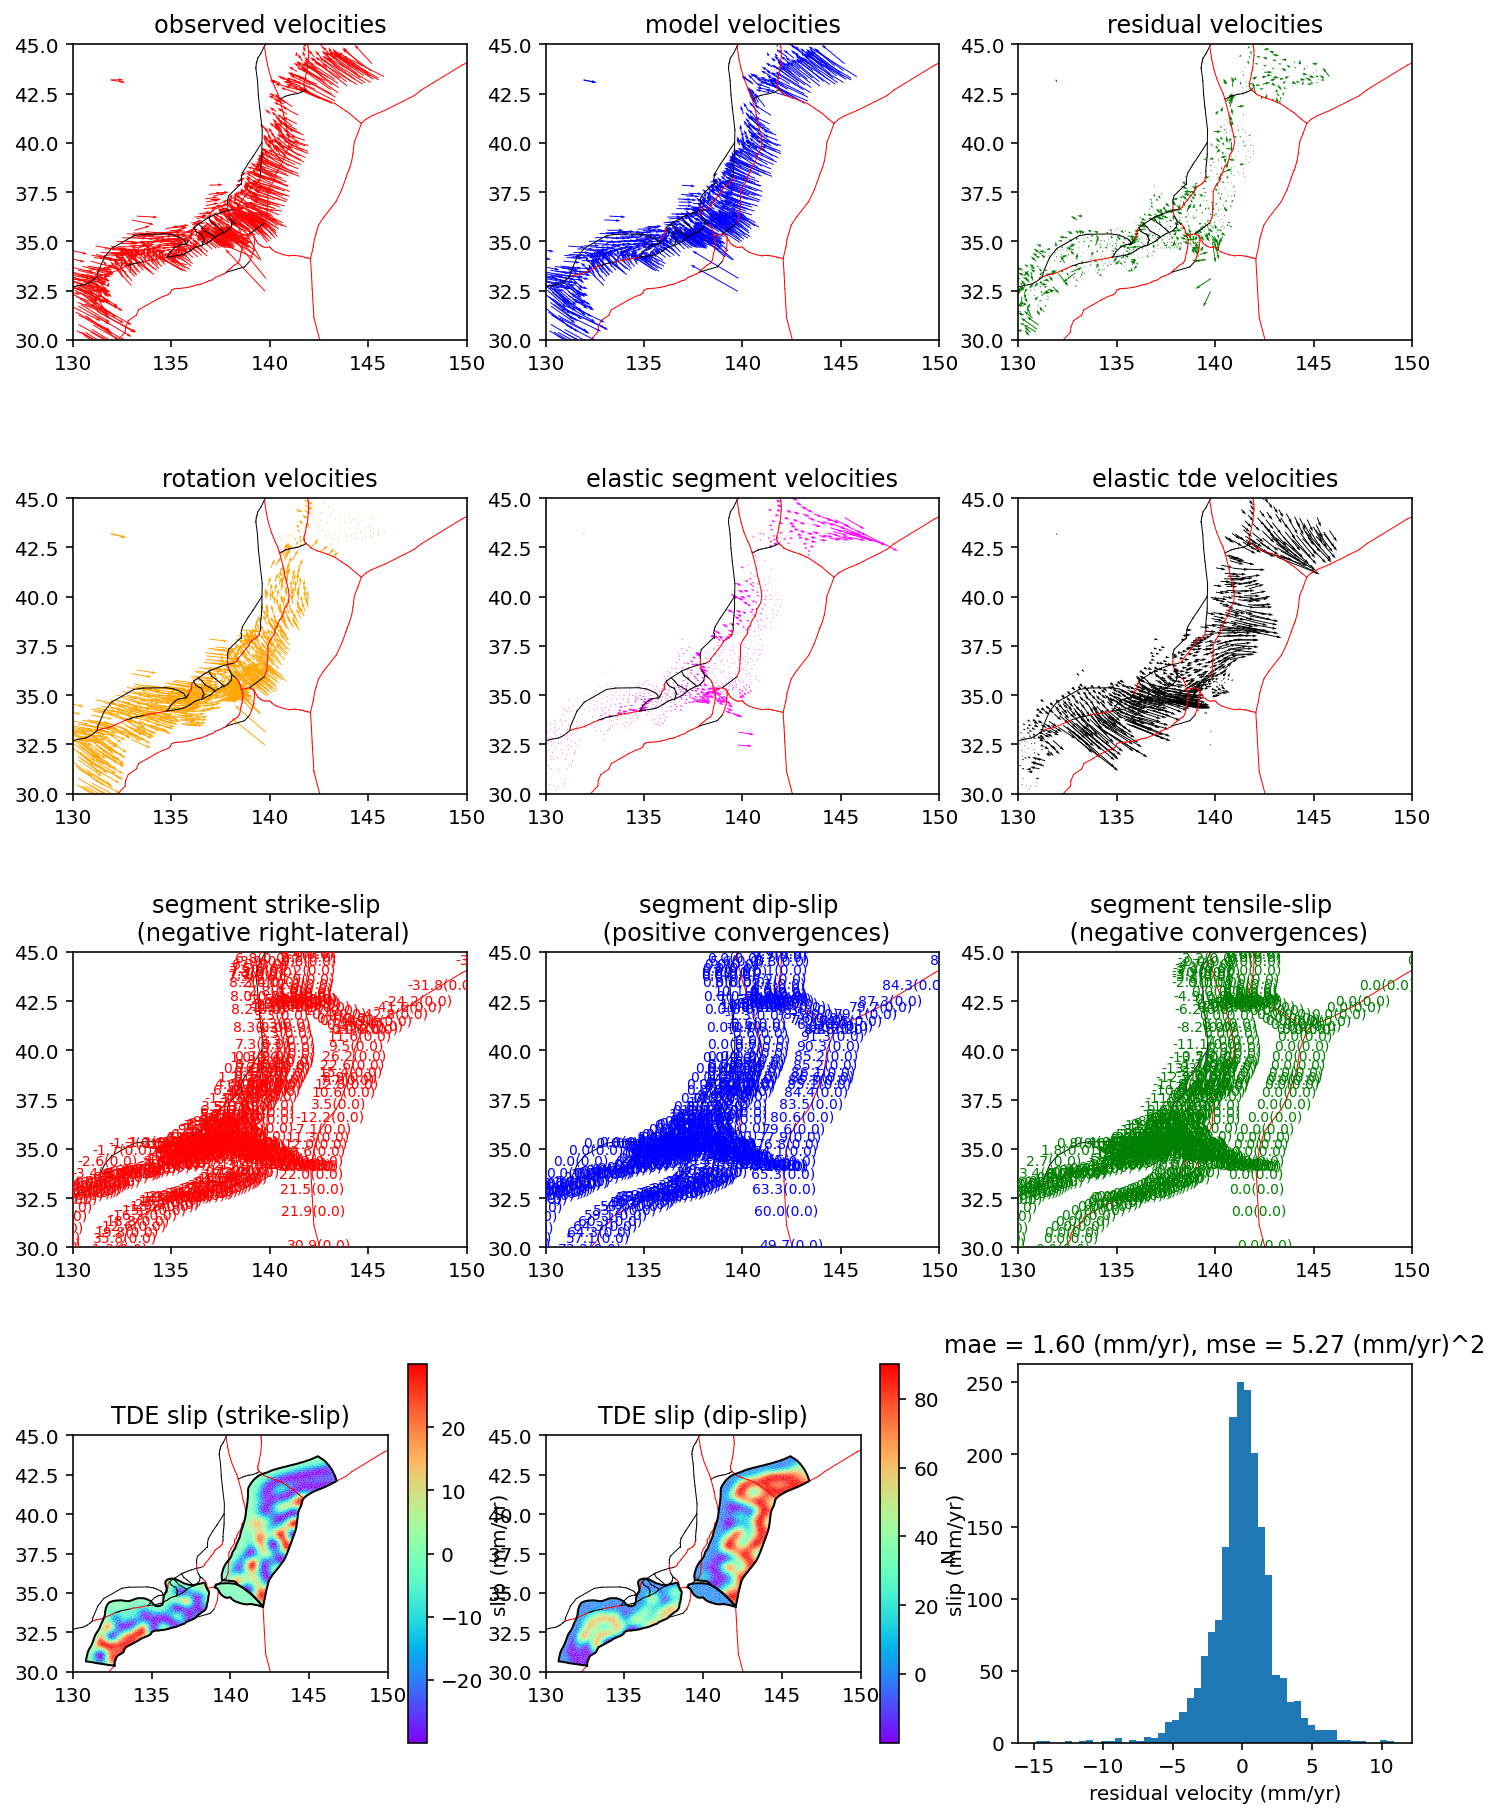

2024-08-22 22:03:47.050 | SUCCESS  | celeri.celeri:plot_estimation_summary:5635 - Wrote figures../runs/0000000343/plot_estimation_summary.(pdf, png)


<Figure size 432x288 with 0 Axes>

In [7]:
celeri.plot_estimation_summary(
    command,
    segment,
    station,
    meshes,
    estimation_qp,
    lon_range=command.lon_range,
    lat_range=command.lat_range,
    quiver_scale=command.quiver_scale,
)